### Sebastián Rodríguez
### 20003076

# Proyecto 1 - Red Neuronal Convolucional

### Elección de dataset

Para trabajar la red neuronal convolucional se decidió utilizar inicialmente un dataset brindado del trabajo para clasificación de distintos tipos de pan hamburguesa, pero se ha tenido mucho problema con el pre-processing del mismo por lo que se optó por clasificación de animales.

El dataset fue elegido en los links brindados del curso https://www.kaggle.com/search?q=tag%3A%22animals%22+in%3Adataset. Se decidió categorizar, realizar data augmentation, un modelo de red convolucional que se explicarás más adelante.

El push de git no ha dejado cargar toda la carpeta de dataset completa, asumo que es por el tamaño. Puede descargarse del siguiente link de drive:
https://drive.google.com/drive/folders/1yCbzFWT0dR0hLx87TdZkibkweU1yxjmX?usp=sharing

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import os.path

In [2]:
anchos, altos = 200, 200
BATCH_SIZE = 64
ruta = 'dataset'

In [3]:
dataGenerator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=5,
    horizontal_flip=True,
    validation_split=0.2
)

In [4]:
Entren_Generador = dataGenerator.flow_from_directory(ruta, 
    target_size=(anchos, altos),
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    #save_to_dir='training',
    subset='training'
)

Prueba_Generador = dataGenerator.flow_from_directory(ruta,
    target_size=(anchos, altos),
    batch_size=BATCH_SIZE, 
    save_to_dir='validacion',
    class_mode='categorical',
    subset='validacion'
)

Found 9570 images belonging to 5 classes.
Found 2391 images belonging to 5 classes.


In [5]:
x_b, y_b = Prueba_Generador.next()

In [6]:
print("Tamaño del batch X: ", x_b.shape)
print("Tamaño de los labels Y: ", y_b.shape)


Tamaño del batch X:  (64, 200, 200, 3)
Tamaño de los labels Y:  (64, 5)


#### Modelo

Creamos capas de convoluciòn de 32 canales con activaciones relu y pooling para bajar dimension en la imagen progresivamente sin sacrificar la interpretabilidad de las caracterìsticas que puede aprender. 

La capa de salida cuenta con 64 canales de salida con la misma función de activación y prevenimos overfitting con una capa de dropout durante el entrenamiento 

Las capas incrementan hasta la salida final de 128 neuronas con la salida activación softmax. El resumen se encuentra abajo.

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(anchos, altos, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

# 64
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

#Dropout
model.add(Dropout(rate=0.25))
# Capa de Flatten, para aplanar la salida bidimensional hacia una capa densa
model.add(Flatten())
# 128
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.5))
# Y
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

### Checkpoint

In [8]:
Archivo_Pesos = "Pesos_futuroentrenamiento.hdf5"
checkpoint = ModelCheckpoint(Archivo_Pesos, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

if os.path.exists(Archivo_Pesos):
    print("Archivo de pesos cargado.")
    model.load_weights(Archivo_Pesos)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print("Modelo compilado.")

Modelo compilado.


In [ ]:
Gen_Nuevo = model.fit_generator(
    generator=Entren_Generador,
    steps_per_epoch= (Entren_Generador.samples // BATCH_SIZE),
    validation_data=Prueba_Generador,
    validation_steps= (Prueba_Generador.samples // BATCH_SIZE), 
    epochs=10,
    callbacks=[checkpoint],
    use_multiprocessing=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
134/149 [=========================>....] - ETA: 23s - loss: 1.4066 - accuracy: 0.4142

In [29]:
Perdida_Pruebas, Accuracy = model.evaluate_generator(generator=Prueba_Generador)
print("F Costo: ", Perdida_Pruebas)
print("Accuracy: ", Accuracy)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Costo de prueba:  0.5267417430877686
Accuracy de prueba:  0.8209953904151917


# Paper

Uno de los paper menciona acerca de la densidad en redes convolucionales. En esta aplica que si tenemos l cantidades de capas y cierta cantidad de conexiones podemos hacer el càlculo de conexiones directas a la capa por medio de (L(L+1))/2. La degradación del gradiente y la fortaleces la propagación de features. Para este problema considero elemental hacer la reducción de número de parámetros. 

In [30]:
Entren_Generador.class_indices

{'butterflies': 0, 'chickens': 1, 'elephants': 2, 'horses': 3, 'spiders': 4}

In [31]:
inv_class_dict = {v: k for k, v in Entren_Generador.class_indices.items()}
inv_class_dict

{0: 'butterflies', 1: 'chickens', 2: 'elephants', 3: 'horses', 4: 'spiders'}

In [32]:
def Prediccion(x, label, model, inv_dict):
    labelpred = model.predict_classes(x.reshape(1, anchos, altos, -1))[0]
    clase = inv_dict[labelpred]
    clase_actual = inv_dict[label]
    plt.imshow(x)
    plt.axis('off')
    plt.title("%s" % clase)

def Matriz_elem(X, labels, n, model, inv_dict, columns=5):
    N = X.shape[0]
    index = np.random.randint(0, N, n)
    x_b = X[index]
    labels_batch = labels[index]
    rows = np.ceil(n / columns).astype(np.int)
    plt.figure(figsize = (16,10))
    for i in range(n):
        plt.subplot(rows, columns, i+1)
        Prediccion(x_b[i], labels_batch[i], model, inv_dict)

In [33]:
def graficarElementos(X, labels, n, model, inv_dict, columns=5):
    N = X.shape[0]
    rnd_idx = np.random.randint(0, N, n)
    x_batch = X[rnd_idx]
    labels_batch = labels[rnd_idx]
    rows = np.ceil(n / columns).astype(np.int)
    plt.figure(figsize = (16,10))
    for i in range(n):
        plt.subplot(rows, columns, i+1)
        predictElement(x_batch[i], labels_batch[i], model, inv_dict)

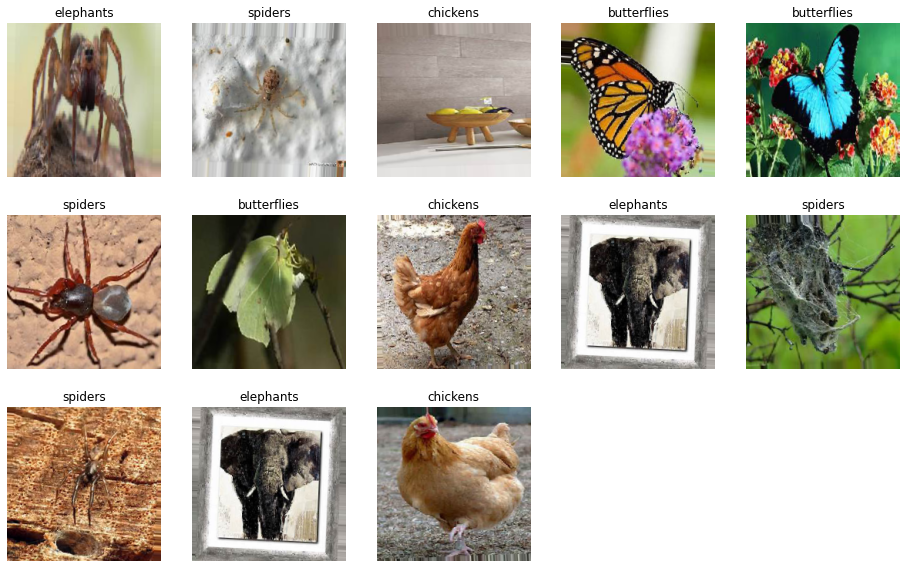

In [35]:
labels = np.argmax(y_b, axis=1)
Matriz_elem(x_b, np.argmax(y_b, axis=1), 13, model, inv_class_dict)

In [36]:
Pesos_red, bias_red = model.layers[0].get_weights()
Pesos_red.shape

(3, 3, 3, 32)

In [37]:
Pesos_red[:, :, 0, 0]

array([[ 0.10104312,  0.09890625,  0.06143565],
       [ 0.05016615, -0.106982  ,  0.03612488],
       [ 0.00943261,  0.00350265, -0.05131755]], dtype=float32)

# Conclusiones

El modelo logra clasificar de manera correcta la mayor cantidad de imagenes con distintos experimentos al momento de correrlo. Posiblemente aumentando el set de datos y logrando mayor data augmentation logremos mejorar la precisión de nuestro programa sacrificando velocidad. El set de checkpoint ha sido la mejor herramienta para solventar esto último y podemos mejorar el modelo más adelante. 

El proceso de entrenamiento y pruebas podrìa extenderse, pero considero que cumple con el objetivo de clasificación que se planteaba en un inicio. 